# Data Mining and Machine Learning Assignment 1: Data Analytics

## Introduction

This notebook includes three real-world examples prepared for the first assignment of summer Machine Learning course. Each example shows how machine learning can be used to understand user behavior in different areas:

- Smart Home/IoT: analyzing household power consumption data collected over 47 months in France to identify daily usage patterns like “Morning Peak” and “Evening Peak”

- Entertainment/Streaming: using Spotify listening history to find similar tracks and illustrate personalized music recommendations with machine - --- learning

- Gaming/Esports: recommending new Steam games to users based on playtime patterns of similar players, showcasing collaborative filtering techniques

In each case, we process the data, apply a basic machine learning technique, and present a clear visualization of the result.

## Smart Home / Internet of Things (IoT)
### About the dataset:
This dataset contains over 47 months of minute-level power usage from a single household in France. It records the electricity consumption of three sub-meters (e.g., kitchen, laundry, etc.), enabling analysis of daily routines and energy usage patterns.

In [6]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [117]:
df = pd.read_csv(
    'household_power_consumption.txt',
    sep=';',
    na_values='?',
    low_memory=False
)
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)
# Set parsed datetime as index
df.set_index('datetime', inplace=True)
# Drop original  columns
df.drop(columns=['Date', 'Time'], inplace=True)
# Convert target column to float
df['Global_active_power'] = df['Global_active_power'].astype(float)
df.head()
print(df.shape)
daily_df.columns = daily_df.columns.astype(str)


(2075259, 7)


In [118]:
hourly_avg = df['Global_active_power'].resample('h').mean()
daily_profiles = hourly_avg.groupby(hourly_avg.index.date).apply(lambda x: x.values[:24])
# Rows = days, Columns = hours 0, 1, 2,...23
daily_df = pd.DataFrame(daily_profiles.tolist())
# drop days with missing vals
daily_df = daily_df.dropna()
daily_df.columns = daily_df.columns.astype(str)
daily_df.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
1,1.882467,3.349400,1.587267,1.662200,2.215767,1.996733,1.303300,1.620033,1.890567,2.549067,...,2.092633,2.985400,3.326033,3.406767,3.697100,2.908400,3.361500,3.040767,1.518000,0.437733
2,0.276367,0.313300,0.284467,0.309933,1.026333,0.293500,0.610000,2.450433,2.082133,1.629333,...,1.733033,1.784300,1.949300,2.154900,2.402533,2.614500,3.050567,2.169733,1.738800,1.547267
3,0.837133,0.353033,0.327233,0.308300,0.327833,0.306667,0.796333,1.785633,3.879033,1.617767,...,0.302133,0.421367,1.372133,2.111500,2.204700,1.842100,2.940533,1.442867,0.720000,0.383700
4,0.459833,0.258667,0.784367,0.310033,0.289000,0.262700,0.283600,1.526633,2.917600,1.385533,...,1.294900,0.281133,0.468433,0.573500,2.836833,3.248633,3.575467,3.646067,3.058967,2.381767
5,1.535867,1.397967,1.274900,0.302600,0.246733,0.290700,0.295667,1.280467,1.563033,2.575800,...,1.023900,0.307400,1.360067,1.752633,2.443300,2.197133,2.437367,0.982267,0.280267,0.270433


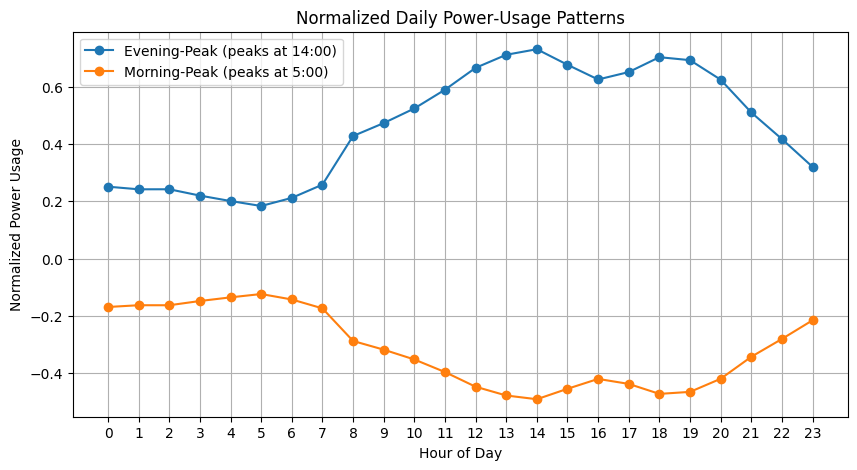

In [119]:
scaled_profiles = StandardScaler().fit_transform(
    daily_df.drop(columns='Cluster', errors='ignore')  # drop any existing label column
)

# 2. Cluster into two usage‐pattern groups
kmeans_model = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans_model.fit_predict(scaled_profiles)
daily_df['UsagePattern'] = cluster_labels

# 3. Extract the two centroids (one per pattern)
cluster_centers = kmeans_model.cluster_centers_

# 4. Name each pattern by its peak‐hour
peak_hours = cluster_centers.argmax(axis=1)
pattern_names = [
    'Morning‑Peak' if hr < 12 else 'Evening‑Peak'
    for hr in peak_hours
]

# 5. Plot the learned usage patterns
plt.figure(figsize=(10, 5))
for idx, centroid in enumerate(cluster_centers):
    plt.plot(
        range(24),
        centroid,
        marker='o',
        label=f'{pattern_names[idx]} (peaks at {peak_hours[idx]}:00)'
    )

plt.title('Normalized Daily Power‑Usage Patterns')
plt.xlabel('Hour of Day')
plt.ylabel('Normalized Power Usage')
plt.xticks(range(0, 24))
plt.legend()
plt.grid(True)
plt.show()

## Entertainment/Streaming
### About the dataset:
This dataset includes individual listening sessions from Spotify, capturing track names, play duration (in milliseconds), and timestamps. It allows us to analyze how users interact with music, such as how long they listen and which songs they frequently return to.

In [120]:
df = pd.read_csv('spotify_history.csv')
df.head()

,spotify_track_uri,ts,platform,ms_played,track_name,artist_name,album_name,reason_start,reason_end,shuffle,skipped
0,2J3n32GeLmMjwuAzyhcSNe,2013-07-08 02:44:34,web player,3185,"Say It, Just Say It",The Mowgli's,Waiting For The Dawn,autoplay,clickrow,False,False
1,1oHxIPqJyvAYHy0PVrDU98,2013-07-08 02:45:37,web player,61865,Drinking from the Bottle (feat. Tinie Tempah),Calvin Harris,18 Months,clickrow,clickrow,False,False
2,487OPlneJNni3NWC8SYqhW,2013-07-08 02:50:24,web player,285386,Born To Die,Lana Del Rey,Born To Die - The Paradise Edition,clickrow,unknown,False,False
3,5IyblF777jLZj1vGHG2UD3,2013-07-08 02:52:40,web player,134022,Off To The Races,Lana Del Rey,Born To Die - The Paradise Edition,trackdone,clickrow,False,False
4,0GgAAB0ZMllFhbNc3mAodO,2013-07-08 03:17:52,web player,0,Half Mast,Empire Of The Sun,Walking On A Dream,clickrow,nextbtn,False,False


In [121]:
# Convert timestamp column to datetime
df['timestamp'] = pd.to_datetime(df['ts'], errors='coerce')

# Drop rows with missing essential info
df = df.dropna(subset=['timestamp', 'track_name', 'artist_name', 'ms_played'])

# Filter out listens with zero or very low playtime (e.g., less than 5 seconds)
df = df[df['ms_played'] > 5000]

# Remove duplicates (optional, but safe)
df = df.drop_duplicates()

# Add date and hour columns for aggregation
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour

print(f"Cleaned data shape: {df.shape}")
df.head()

Cleaned data shape: (104939, 14)


,spotify_track_uri,ts,platform,ms_played,track_name,artist_name,album_name,reason_start,reason_end,shuffle,skipped,timestamp,date,hour
1,1oHxIPqJyvAYHy0PVrDU98,2013-07-08 02:45:37,web player,61865,Drinking from the Bottle (feat. Tinie Tempah),Calvin Harris,18 Months,clickrow,clickrow,False,False,2013-07-08 02:45:37,2013-07-08,2
2,487OPlneJNni3NWC8SYqhW,2013-07-08 02:50:24,web player,285386,Born To Die,Lana Del Rey,Born To Die - The Paradise Edition,clickrow,unknown,False,False,2013-07-08 02:50:24,2013-07-08,2
3,5IyblF777jLZj1vGHG2UD3,2013-07-08 02:52:40,web player,134022,Off To The Races,Lana Del Rey,Born To Die - The Paradise Edition,trackdone,clickrow,False,False,2013-07-08 02:52:40,2013-07-08,2
5,50VNvhzyaSplJCKWchN7a8,2013-07-08 03:17:52,web player,63485,Impossible,James Arthur,Impossible,clickrow,clickrow,False,False,2013-07-08 03:17:52,2013-07-08,3
10,07hII2Rc29q4F2nTE3P1od,2013-07-08 03:20:20,web player,67587,Sun - Gildas Kitsunй Club Night Short Remix,Two Door Cinema Club,The Kitsuné Special Edition #3 (Kitsuné Maison...,clickrow,clickrow,False,False,2013-07-08 03:20:20,2013-07-08,3


In [122]:
# Aggregate listens per day per track
daily_track_stats = df.groupby(['date', 'track_name']).agg(
    total_playtime_ms=('ms_played', 'sum'),
    first_hour=('hour', 'min'),
    listen_count=('ms_played', 'count')
).reset_index()

# Label: "liked" if listened more than once per day
daily_track_stats['liked'] = (daily_track_stats['listen_count'] > 1).astype(int)

# Get artist for each track (from original data)
first_artist = df.groupby('track_name')['artist_name'].first().reset_index()

# Merge artist info
daily_track_stats = daily_track_stats.merge(first_artist, on='track_name', how='left')

# Compute artist popularity (unique tracks per artist)
artist_popularity = df.groupby('artist_name')['track_name'].nunique().reset_index()
artist_popularity.columns = ['artist_name', 'artist_popularity']

daily_track_stats = daily_track_stats.merge(artist_popularity, on='artist_name', how='left')

# Fill any NaNs
daily_track_stats = daily_track_stats.fillna(0)
daily_track_stats.head()

,date,track_name,total_playtime_ms,first_hour,listen_count,liked,artist_name,artist_popularity
0,2013-07-08,7th Street,81893,3,1,0,John Mayer,110
1,2013-07-08,Born To Die,285386,2,1,0,Lana Del Rey,28
2,2013-07-08,Daughters,237896,4,1,0,John Mayer,110
3,2013-07-08,Daughters - Electric Guitar Mix,78943,4,1,0,John Mayer,110
4,2013-07-08,Do I Wanna Know?,95817,3,1,0,Arctic Monkeys,62


In [131]:
# Example: create a matrix of track play counts (or total playtime) per day
# Pivot so rows = days, columns = tracks, values = total playtime
pivot_df = df.pivot_table(index='date', columns='track_name', values='ms_played', aggfunc='sum').fillna(0)

# Fit NearestNeighbors model on track vectors (transpose matrix)
model_nn = NearestNeighbors(n_neighbors=10, metric='cosine')
model_nn.fit(pivot_df.T)

# Pick a track, e.g. the most played track overall
most_played_track = pivot_df.sum().idxmax()

# Find 5 nearest tracks to the most played one
distances, indices = model_nn.kneighbors(pivot_df.T.loc[[most_played_track]])

print(f"Tracks similar to '{most_played_track}':")
for i in indices[0]:
    print(pivot_df.T.index[i])

Tracks similar to 'Ode To The Mets':
Ode To The Mets
Bad Decisions
Selfless
Why Are Sundays So Depressing
Not The Same Anymore
Brooklyn Bridge To Chorus
The Adults Are Talking
Eternal Summer
At The Door
Que Suerte la Mia - Remastered


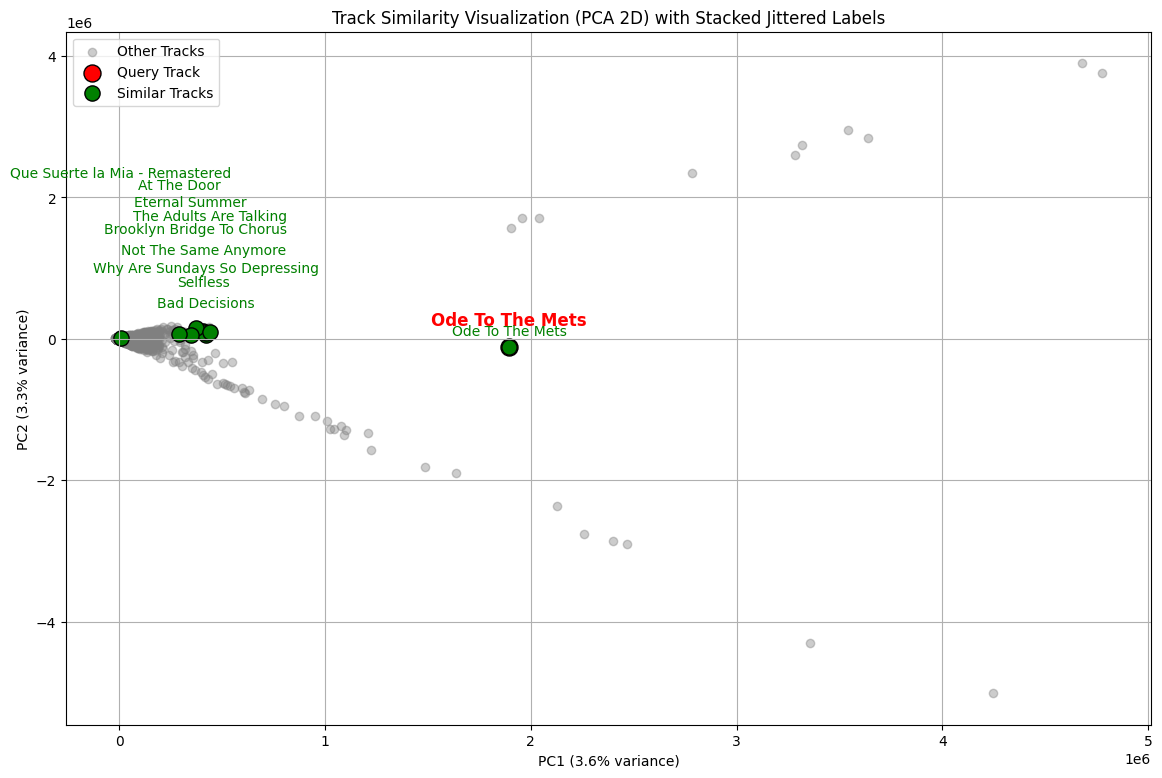

In [136]:
def jitter(values, jitter_amount=0.01):
    return values + np.random.uniform(-jitter_amount, jitter_amount, size=values.shape)

plt.figure(figsize=(14, 9))
plt.scatter(track_vectors_2d[:, 0], track_vectors_2d[:, 1], alpha=0.4, color='gray', label='Other Tracks')

query_index = pivot_df.T.index.get_loc(most_played_track)
neighbors_indices = indices[0]

plt.scatter(track_vectors_2d[query_index, 0], track_vectors_2d[query_index, 1], color='red', label='Query Track', s=150, edgecolors='black')
plt.scatter(track_vectors_2d[neighbors_indices, 0], track_vectors_2d[neighbors_indices, 1], color='green', label='Similar Tracks', s=120, edgecolors='black')

plt.annotate(
    most_played_track,
    (track_vectors_2d[query_index, 0], track_vectors_2d[query_index, 1]),
    textcoords="offset points",
    xytext=(0, 15),
    ha='center',
    fontsize=12,
    fontweight='bold',
    color='red'
)

# Label similar tracks with vertical stacking + jitter
for i, idx in enumerate(neighbors_indices):
    x = track_vectors_2d[idx, 0]
    y = track_vectors_2d[idx, 1]
    
    x_jitter = jitter(np.array([x]), jitter_amount=0.005)[0]
    
    # Stack labels by increasing vertical offset per label index
    y_offset = 8 + i*12  # base offset + 12 points per label stacked up
    plt.annotate(
        pivot_df.T.index[idx],
        (x_jitter, y),
        textcoords="offset points",
        xytext=(0, y_offset),
        ha='center',
        fontsize=10,
        color='green'
    )

plt.title('Track Similarity Visualization (PCA 2D) with Stacked Jittered Labels')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.legend()
plt.grid(True)
plt.show()

## Gaming/Esports
### About the dataset:
The dataset contains over 41 million cleaned and preprocessed user recommendations (reviews) from a Steam Store. Additionally, it contains detailed information about games and add-ons

In [40]:
df = pd.read_csv("recommendations.csv")
df_sample = df.sample(n=5000, random_state=42)
df.head()

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.3,51580,0
1,304390,4,0,2017-02-17,False,11.5,2586,1
2,1085660,2,0,2019-11-17,True,336.5,253880,2
3,703080,0,0,2022-09-23,True,27.4,259432,3
4,526870,0,0,2021-01-10,True,7.9,23869,4


In [41]:
# Create user-game matrix (1 if recommended, 0 otherwise)
df_sample['is_recommended'] = df_sample['is_recommended'].astype(int)
user_game = df_sample.pivot_table(index='user_id', columns='app_id', values='is_recommended', fill_value=0)

In [42]:
random_user = np.random.choice(user_game.index)
print(f"Recommending for User ID: {random_user}")

Recommending for User ID: 8915764


In [43]:
user_similarity = cosine_similarity(user_game)
user_similarity_df = pd.DataFrame(user_similarity, index=user_game.index, columns=user_game.index)

In [54]:
# get top 100 most similar users
similar_users = user_similarity_df[random_user].sort_values(ascending=False)[1:1001]

In [55]:
# # games liked by similar users but not by the original user

user_games = set(user_game.loc[random_user][user_game.loc[random_user] == 1].index)

recommendations = pd.Series(dtype=float)
for sim_user in similar_users.index:
    sim_user_likes = user_game.loc[sim_user]
    recommended_games = sim_user_likes[(sim_user_likes == 1) & (~sim_user_likes.index.isin(user_games))]
    recommendations = recommendations.add(recommended_games, fill_value=0)

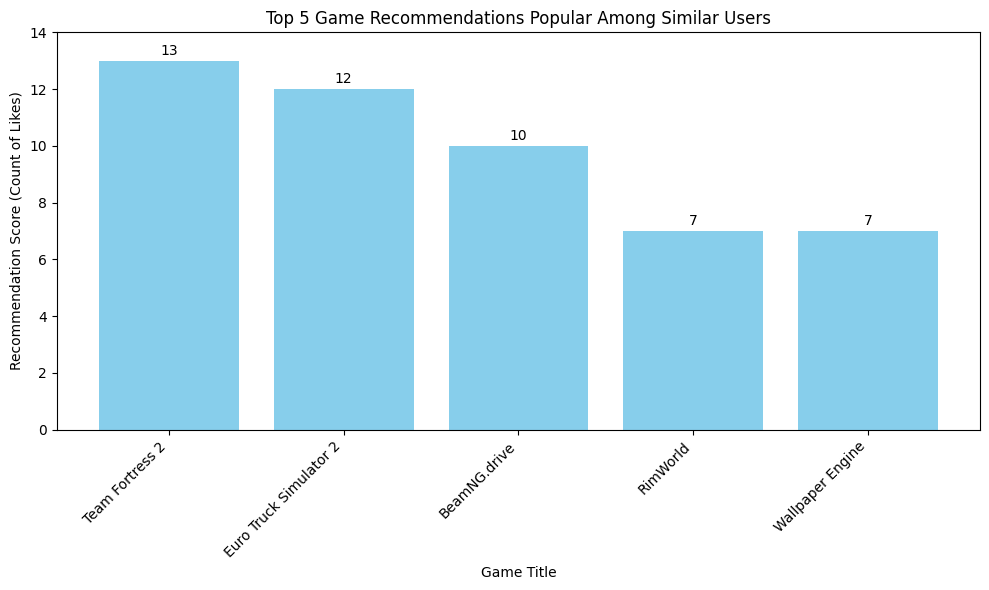

In [56]:
games = pd.read_csv("games.csv")[['app_id', 'title']]

# Sum liked games by similar users
recommendations = user_game.loc[similar_users.index].sum()

# Sort descending and take top 5
top_recommendations = recommendations.sort_values(ascending=False).head(5)

# Convert to DataFrame and merge with titles
top_recommendations_df = pd.DataFrame(top_recommendations).reset_index()
top_recommendations_df.columns = ['app_id', 'score']
top_with_titles = top_recommendations_df.merge(games, on='app_id', how='left')

# Add ranking starting at 1
top_with_titles.insert(0, 'Rank', range(1, len(top_with_titles) + 1))

# Visualization
plt.figure(figsize=(10, 6))
bars = plt.bar(top_with_titles['Rank'], top_with_titles['score'], tick_label=top_with_titles['title'], color='skyblue')
plt.xlabel('Game Title')
plt.ylabel('Recommendation Score (Count of Likes)')
plt.title('Top 5 Game Recommendations Popular Among Similar Users')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, top_with_titles['score'].max() + 1)
plt.tight_layout()

# Add the score label above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.1, f'{height:.0f}', ha='center', va='bottom')

plt.show()